<a href="https://colab.research.google.com/github/gle-bellier/flow-matching/blob/main/Flow_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow Matching
_notebook by Georges Le Bellier_  - [Twitter](https://twitter.com/gle_bellier), [Website](https://gle-bellier.github.io)


This notebook centers around the **Flow Matching for Generative Modeling** article [1] and proposes an implementation of Flow Matching in the case of _Optimal Transport conditional Vector Fields_. The implementation proposed in [2] was consulted and it inspired the use of the _Zuko_ [3] package for ODE solving and sampling. Moreover, this notebook adopts the notations of the original article and thus the numbers of the equations are the same as in the paper.

## References:

📄 [1] **Flow Matching for Generative Modeling** by Yaron Lipman, Ricky T. Q. Chen, Heli Ben-Hamu, Maximilian Nickel, Matt Le - [Article](https://arxiv.org/abs/2210.02747)

🐍 [2] **Flow Matching in 100 LOC** by François Rozet - [Implementation](https://gist.github.com/francois-rozet/fd6a820e052157f8ac6e2aa39e16c1aa)

🐍 [3] **Zuko** package - [Website](https://zuko.readthedocs.io/en/stable/index.html)

## Introduction

$$
\mathcal{L}_{FM}(\theta) = \mathbb{E}_{t, p_t(x)} \lVert v_t(x) - u_t(x) \rVert^2 \tag{5}
$$
$$
\mathcal{L}_{CFM}(\theta) = \mathbb{E}_{t, q(x_1), p_t(x|x_1)} \lVert v_t(x) - u_t(x|x_1) \rVert^2 \tag{9}
$$ 

$$
p_t(x|x_1) = \mathcal{N}(x | \mu_t(x_1), \sigma_t(x_1)^2I) \tag{10}
$$

$$ 
  \psi_t(x) = \sigma_t(x_1)x + \mu_t(x_1) \tag{11}
$$

$$
\frac{d}{dt}\psi_t(x) = u_t(\psi_t(x)|x_1) \tag{13}
$$

$$
\mathcal{L}_{CFM}(\theta) = \mathbb{E}_{t, q(x_1), p(x_0)} \big\lVert v_t(\psi_t(x_0)) - \frac{d}{dt}\psi_t(x_0) \big\rVert^2 \tag{14}
$$


$$
\mathcal{L}_{CFM}(\theta) = \mathbb{E}_{t, q(x_1), p(x_0)} \big\lVert v_t(\psi_t(x_0)) - (x_1 - (1 - \sigma_{min})x_0) \big\rVert^2 \tag{23}
$$





In [63]:
#@title ⚠️ TODO: imports
%%capture 
!pip install zuko
!pip install torchdiffeq

import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from torch import Tensor
from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader
from zuko.utils import odeint
from tqdm import tqdm
from typing import *
import numpy as np
import pandas as pd

## Optimal Transport conditional Vector Fields:

In [64]:
class OTFlowMatching:
  
  def __init__(self, sig_min: float = 0.001) -> None:
    super().__init__()
    self.sig_min = sig_min

$$
\psi_t(x) = (1 - (1 - \sigma_{min})t)x + tx_1 \tag{22}
$$


In [65]:
  def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """ Conditional Flow
    """
    t = t[:, None].expand(x.shape)
    return (1 - (1 - self.sig_min) * t) * x + t * x_1

$$
\mathcal{L}_{CPM}(\theta) = \mathbb{E}_{t, q(x_1), p(x_0)} \big\lVert v_t(\psi_t(x_0)) - \frac{d}{dt}\psi_t(x_0) \big\rVert^2 \tag{14}
$$

$$
\mathcal{L}_{CPM}(\theta) = \mathbb{E}_{t, q(x_1), p(x_0)} \big\lVert v_t(\psi_t(x_0)) - (x_1 - (1 - \sigma_{min})x_0) \big\rVert^2 \tag{23}
$$



In [66]:
  def loss(self, v_t: nn.Module, x_0: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """ 
    v_psi = v_t(t, self.psi_t(x_0, x_1, t))
    d_psi = x_1 - (1 - self.sig_min) * x_0
    return torch.mean((v_psi - d_psi) ** 2)

Summary:

In [67]:
class OTFlowMatching:
  
  def __init__(self, sig_min: float = 0.001) -> None:
    super().__init__()
    self.sig_min = sig_min

  def psi_t(self, x: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """ Conditional Flow
    """
    t = t[:, None].expand(x.shape)
    return (1 - (1 - self.sig_min) * t) * x + t * x_1

  def loss(self, v_t: nn.Module, x_0: torch.Tensor, x_1: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """ Compute loss
    """ 
    v_psi = v_t(t, self.psi_t(x_0, x_1, t))
    d_psi = x_1 - (1 - self.sig_min) * x_0
    return torch.mean((v_psi - d_psi) ** 2)

## Conditional Vector Field:

We add the ```CondVF```  class which aims to model the _Optimal Transport Conditional Vector Field_ $v_t$. This approximation $v_{t}(\;⋅\;;\theta)$ of the true $v_t$ will be optimized later in this notebook by tuning the parameters $\theta$ of ```CondVF.net```. 

In [68]:
class CondVF(nn.Module):
  def __init__(self, net: nn.Module) -> None:
    super().__init__()
    self.net = net

In [69]:
  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    return self.net(t, x)

Furthermore, we define the ```encode``` and ```decode``` functions:
- ```encode``` maps the data distribtion $q(x_1)$ to the prior distribution $p(x_0)$.
- ```decode``` maps the prior distribution $p(x_0)$ to the data distribtion $q(x_1)$.

The article mentions that the flow $\phi_t$ verifies the following equations:
$$
\begin{cases}
  \frac{d}{dt}\phi_t(x) = v_t(\phi_t(x))\\ 
  \phi_0(x) = x \tag{1, 2}\\
\end{cases}
$$

Thus, to ```encode``` we will integrate the first equation from $t=1$ to $t=0$ and the ```decode``` function will be the same but going from $t=0$ to $t=1$. Following François Rozet's implementation and side notes [2], we use the function ```odeint``` from the _Zuko_ package [3]. We build a small ```wrapper``` which only aims at providing time tensor with the correct shapes to the neural network ```net``` when using ```odeint```.

In [70]:
  def wrapper(self, t: torch.Tensor, x: torch.Tensor):
      t = t * torch.ones(len(x))
      return self(t, x)

  def encode(self, x_1: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_1, 1., 0., self.parameters())

  def decode(self, x_0: torch.Tensor) -> Tensor:
    return odeint(self.wrapper, x_0, 0., 1., self.parameters())

Summary:

In [71]:
class CondVF(nn.Module):
  def __init__(self, net: nn.Module, n_steps: int = 100) -> None:
    super().__init__()
    self.net = net

  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    return self.net(t, x)
    
  def wrapper(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
      t = t * torch.ones(len(x))
      return self(t, x)

  def encode(self, x_1: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_1, 1., 0., self.parameters())

  def decode(self, x_0: torch.Tensor) -> torch.Tensor:
    return odeint(self.wrapper, x_0, 0., 1., self.parameters())

## Neural Network for VF approximation:

We want to approximate $v_t$ with a parametric model $v_{t}(\;\cdot\;;\theta)$. Since we deal with point coordinates and want to keep the neural network simple for this example, we will use a simple _Multilayer Perceptron_ (MLP).

In [72]:
class Net(nn.Module):
  def __init__(self, in_dim: int, out_dim: int, h_dims: List[int], n_frequencies: int) -> None:
    super().__init__()

    ins = [in_dim + 2 * n_frequencies] + h_dims
    outs = h_dims + [out_dim]
    self.n_frequencies = n_frequencies

    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)
    ])
    self.top = nn.Sequential(nn.Linear(out_dim, out_dim))

 However the vector field $v$ is conditioned on time $t$. Thus, we create a _sinusoidal positional encoding_ of $t$ thanks to sine and cosine functions.

In [73]:
  def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
    freq = 2 * torch.arange(self.n_frequencies) * torch.pi
    t = freq * t[..., None]
    return torch.cat((t.cos(), t.sin()), dim=-1)

When computing $v_t(x)$ we simply concatenate the _sinusoidale positional encoding_ of $t$ with $x$ (input coordinates), and then process the input tensor with the MLP's layers.

In [74]:
  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    t = self.time_encoder(t)
    x = torch.cat((x, t), dim=-1)
    for l in self.layers:
      x = l(x)
    return 

Summary: please run this cell which contains the Net class.

In [75]:
class Net(nn.Module):
  def __init__(self, in_dim: int, out_dim: int, h_dims: List[int], n_frequencies) -> None:
    super().__init__()

    ins = [in_dim + 2 * n_frequencies] + h_dims
    outs = h_dims + [out_dim]
    self.n_frequencies = n_frequencies

    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)
    ])
    self.top = nn.Sequential(nn.Linear(out_dim, out_dim))
  
  def time_encoder(self, t: torch.Tensor) -> torch.Tensor:
    freq = 2 * torch.arange(self.n_frequencies) * torch.pi
    t = freq * t[..., None]
    return torch.cat((t.cos(), t.sin()), dim=-1)
    
  def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    t = self.time_encoder(t)
    x = torch.cat((x, t), dim=-1)
    
    for l in self.layers:
      x = l(x)
    return x

## Create dataset

For this notebook we will consider a 2D-dataset and we choose a standard dataset: the _half-moon dataset_. This defines the distribution $q(x_1)$ over the  $\mathbb{R}^2$ data space, _i.e._ the data points are described by two coordinates $x = (a, b)$. We sample a large number ```n_points``` of data points from $q(x_1)$ to build the dataset and we plot them. In addition, in this work we consider a simple gaussian _prior distribution_:
$$
p(x) = \mathcal{N}(x|0, I)
$$

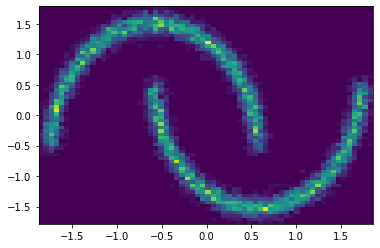

In [76]:
n_points = 10_000
data, _ = make_moons(n_points, noise=0.05)
# center dataset
data = StandardScaler().fit_transform(data)

%matplotlib inline
plt.hist2d(data[:, 0], data[:, 1], bins=64)
plt.show()

We then transform the data points into a ```pytorch.utils.data.DataLoader``` to facilitate data handling. We choose a ```batch_size``` of $512$.

In [77]:
batch_size = 512
dataset = torch.from_numpy(data).float()
dataset = TensorDataset(dataset) 
dataloader = DataLoader(dataset, batch_size=batch_size)

## Training:

During the training, we need to compute the _Continuous Flow Matching_ Loss:
$$
\mathcal{L}_{CPM}(\theta) = \mathbb{E}_{t, q(x_1), p(x_0)} \big\lVert v_t(\psi_t(x_0)) - (x_1 - (1 - \sigma_{min})x_0) \big\rVert^2 \tag{23}
$$
Then we sample $x_1 \sim q(x_1)$ (samples from the dataset), $x_0 \sim p(x_0)$ (samples from the _prior distribution_) and $t \sim \text{Unif}([0, 1])$. It is worth noticing that we apply a little trick for time sampling since we batch covers the range $[0, 1]$ uniformly with a random offset. Then we compute an approximation of the _CFM Loss_ on the batch: 
$$
\mathcal{L}_{\text{batch}}(\theta) = \frac{1}{N}\sum_{i=0}^{N-1} \big\lVert v_t\big(\psi_t\big(x_0^{(i)}\big)\big) - \big(x_{1}^{(i)} - \big(1 - \sigma_{min}\big)x_0^{(i)}\big) \big\rVert^2
$$


In [78]:
def training_loss(fm_loss: Callable, v_t: Callable, batch: torch.Tensor) -> torch.Tensor:
      # x_1 ~ q(x_1)
      x_1 = batch[0]
      # x_0 ~ p(x_0)
      x_0 = torch.randn_like(x_1)
      # t ~ U([0, 1])
      # simple sampling:
      # t = torch.rand(len(x_1),)
      # trick:
      t = (torch.rand(1) + torch.arange(len(x_0)) / len(x_0)) % 1
      
      return fm_loss(v_t, x_0, x_1, t)

We train the neural network using the ```AdamW``` optimizer (Adam optimizer with _weight decay_) with a _learning rate_ $lr = 10^{-3}$ during $N = 500$ epochs:

In [79]:
fm = OTFlowMatching()
net = Net(2, 2, [32, 128, 256, 128, 64], 10)
v_t = CondVF(net)    
    
# configure optimizer
optimizer = torch.optim.AdamW(v_t.parameters(), lr=1e-3)
n_epochs = 500
    
for epoch in tqdm(range(n_epochs), ncols=88):
    for batch in dataloader: 
      # compute loss 
      loss = training_loss(fm.loss, v_t, batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

100%|█████████████████████████████████████████████████| 500/500 [03:01<00:00,  2.76it/s]


## Sampling:

To sample $\hat{x}_{1} \sim q(x_1)$ we first sample $x_0 \sim p(x)$, _i.e._ we take samples from the _prior distribution_ and then apply the ```decode``` function from the ```CondVF``` class. This step may take several minutes depending on the ```n_samples``` chosen.

In [85]:
# Sampling
n_samples = 10_000
with torch.no_grad():
    x_0 = torch.randn(n_samples, 2)
    x_1_hat = v_t.decode(x_0)

Last, we plot the samples $\hat{x}_1$ distribution:

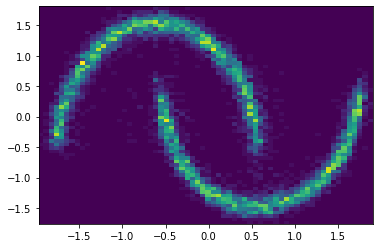

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
x_1_hat = x_1_hat.numpy()
plt.hist2d(x_1_hat[:, 0], x_1_hat[:, 1], bins=64)
plt.show()